# Face Recognition Project

В этом проектк вы познакомитесь с задачей распознавания лиц, узнаете, как ее решать, и построите свой пайплан для решения этой задачи.

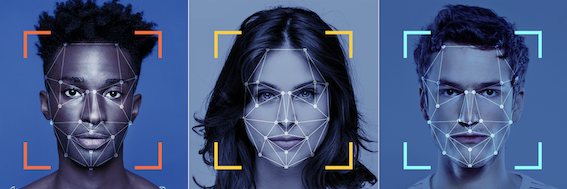

Для начала познакомимся с тем, как работает стандартный пайплан для распознавания лиц. Это не одна нейросеть, которая делает всю работу: это целых три отдельных стадии. После этого в разделе "задача проекта" расписано то, что нужно/можно делать в рамках этого проекта. **Пожалуйста, перед началом работы по проекту внимательно прочитайте раздел "задача проекта"!**

Ну а перед этим всем лучше разберемся с тем, какую задачу вообще мы хотим решать.

## Постановка задачи

Допустим, вы владеете компанией и хотите разработать систему распознавания лиц, чтобы применять ее в своем офисе. Например, чтобы ваши сотрудники могли сканировать лицо вместо прикладывания id карточек к турникетам при входе. Или для обеспечения безопасности в офисах (да, вы — хороший владелец компании, и используете face recognition только для обеспечения безопасности. Никакие данные не собираете, нигде долго не храните и никуда не передаете)  

Получается, вам нужна система, которая может принимать на вход видео, полученное с камер наблюдения, и на выходе выдавать, что за люди были замечены на этом видео. Ваша система должна уметь работать в случаях, когда лица людей запечатлены крупным или мелким планом, когда они чуть повернуты или наклонены, и когда на одном кадре с камеры находятся несколько лиц людей.

Вот решением такой задачи мы сейчас и займемся.

## Пайплайн для распознавания лиц, его обучение и тест

В этой части описано устройство пайплайна для распознавания лиц, а также принцип его обучения и тестирования.

### Пайплайн распознавания лиц

Обычно система распознавания лиц состоит из трех элементов:

- детекция лица (face detection);
- выравнивание лица (face alignment);
- распознавания лица (face recognition).

Давайте обсудим все этапы подробнее:

#### Детекция лиц

Пусть мы получили кадр с камеры наблюдения, на котором мы хотим распознать лица. Этот кадр может выглядеть как-то так:

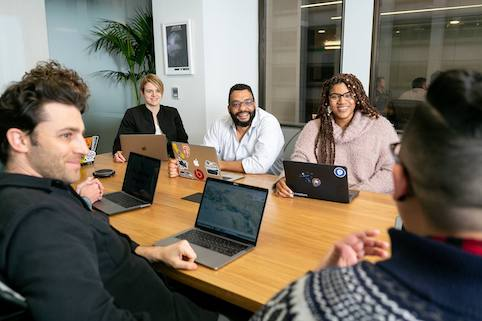

Первый этап обработки фото — детекция лиц на нем. Результат детекции может выглядеть примерно так:

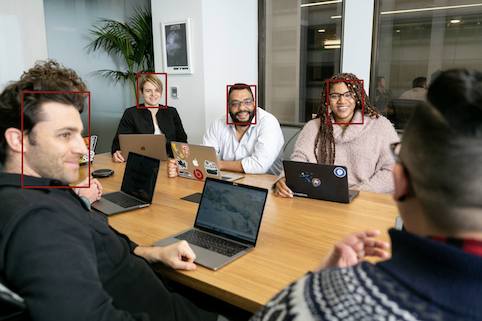

Для детекции лиц на фото может использоваться модель (например, нейросеть), обученная на задачу детекции лиц людей.

#### Выравнивание лиц


После этапа детекции работа с каждым детектированным лицом идет по отдельности
(точнее, с bounding box'ами каждого детектированного лица).

Второй этап — выравнивание лица. Он состоит из двух этапов:
1. На картинке ищутся ключевые точки лица (обычно это координаты зрачков глаз, кончик носа и точки вокруг рта). Для этой задачи используется отдельная модель (возможно, тоже нейросеть). У PyTorch есть [туториал](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) с кодом и описанием того, как подобная модель работает;
2. Повернуть и растянуть изображение так, чтобы точки глаз лица лежали на заданной горизонтальной линии, и чтобы между зрачками глаз было определенное расстояние.

Вот так это может выглядеть:

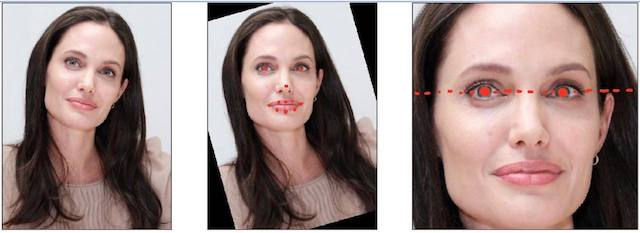

Таким образом, после второго этапа лица выглядят как-то так:

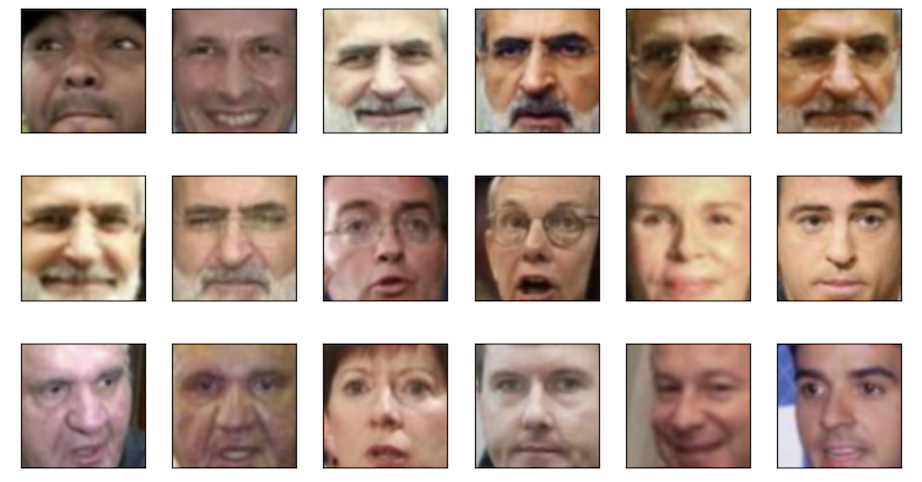

На таких картинках лиц и будет работать третья часть пайплайна — нейросеть, которая распознает лица.

**Зачем нужна стадия выравнивания**: выравнивание лиц датасета делает задачу распознавания лиц проще для модели на третьей стадии пайплайна. Если у всех лиц, которые принимает на вход модель, примерно одинаковый размер и все ключевые части (глаза, нос, рот) находятся в примерно одинаковых местах, это упрощает модели задачу понимания того, что за человек изображен на картинке. Модели не нужно "искать" глаза, рот и т.п. на картинке.

Практика подтверждает, что это сильно улучшает эффективность модели: без стадии выравнивания практически невозможно обучить хорошую систему распознавания лиц. Точнее, возможно, но только если есть очень-очень-очень много обучающих данных. Больше, чем практически у всех даже больших компаний.

#### Распознавание лиц

Третья часть пайплайна — это, собственно, распознавание лиц.

Что такое "распознавание": мы хотим построить такую нейросеть, которая принимает на вход картинку лица, а выдает вектор определенного размера. И мы хотим, чтобы векторы лиц одного и того же человека были близки по некоторому расстоянию (например, косинусному), а векторы лиц разных людей были далеки по этому же расстоянию. Обычно в качестве расстояния используется [косинусное расстояние](https://en.wikipedia.org/wiki/Cosine_similarity) (cosine distance).

Почему мы хотим построить именно такую сеть? Почему не посмтроить обычную сеть для классификации и научить ее классифицировать лица из обучающей выборки, где каждый отдельный человек — это один класс? Ответ такой — мы хотим, чтобы наша модель умела работать с лицами людей, которых нет в обучающей выборке. Хотим, чтобы она на лица одного и того же незнакомого человека выдавала близкие векторы (т.е. "говорила" нам, что это один и тот же человек), а на лица разных людей — далекие векторы.

Пусть тогда у нас есть база данных людей вида (id, набор векторов его лиц). Когда к нам придет новая картинка лица, мы ее прогоним через модель и получим вектор этого лица. Далее сравним этот вектор по метрике расстояния с векторами из нашей базы. Тот id, чьи векторы будут наиболее близки к нашему, и будет ответом на вопрос "кто изображен на картинке"



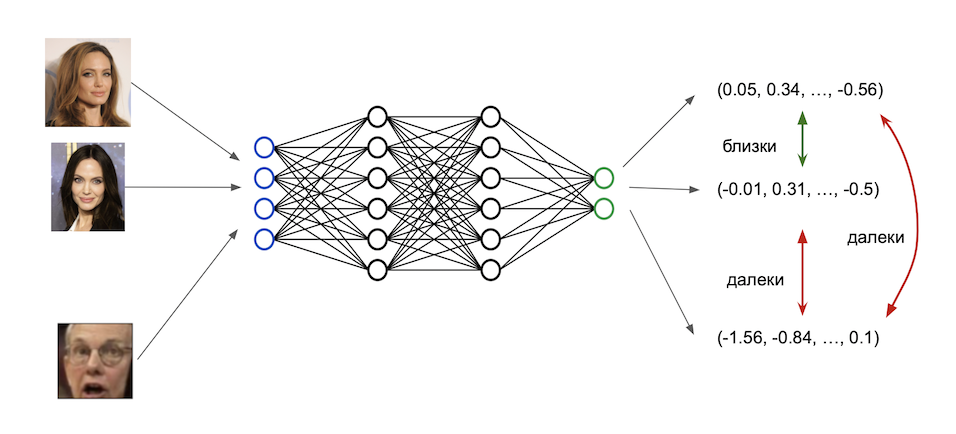

Такую сеть можно обучать разными способами. Два самых распространенных — такие:

1. Можно обучить нейросеть на обучающей выборке лиц на задачу классификации. Каждый отдельный человек — это один класс. В качестве лосс-функции можно использовать стандартную кросс-энтропию или специальные ее модификации (разберем ниже в ноутбуке). Затем, после обучения сети, выкинуть последний слой и считать вектором лица выход предпоследнего слоя сети. Это будет работать: полученные таким образом векторы лиц действительно будут близки для лиц одного и того же человека, и далеки для лиц разных людей. Причем это будет работать даже на тех лицах, которые не было в обучающей выборке (при условии, что обучающая выборка достаточно велика).

    У этого подхода есть недостаток: классов в обучающем датасете может быть очень много. Из-за этого последний слой сети станет очень широким. Это сделает обучение сети вычислительно затратным и сложным по памяти. Иногда приходится этот последний слой делить на несколько разных GPU, настолько он бывает большим.
2.  Можно пойти другим путем: обучать сеть напрямую на задачу "выдавать похожие эмбеддинги для лиц одного и того же человека, и далекие эмбеддинги для лиц разных людей". Это называется **contrastive training**.
    
    На каждой итерации обучения тогда происходит следующее:
    - берется картинка лица, к ней выбирается позитивная пара (еще одна картинка лица того же человека) и негативная (картинка лица другого человека). Все три картинки подаются на вход сети, на выходе получаются три вектора. Далее считается расстояние между векторами 1 и 2 и расстояние между векторами 1 и 3. Нейросеть обучается так, чтобы расстояние между векторами 1 и 2 было как можно меньше, а расстояние между векторами 1 и 3 — как можно больше.

    Лосс-функция в этом случае выглядит так:

 $$L = D(anchor, positive) - D(anchor, negative)$$

**Contrastive loss** - используются два изображения и лэйбл, указывающий на то, похожи они или нет.
**Triplet loss** - используются anchor, positive и negative.
В данном случае формула указана для triplet loss, поэтому добавлю сюда формулу для Contrastive loss, которую буду использовать для модели.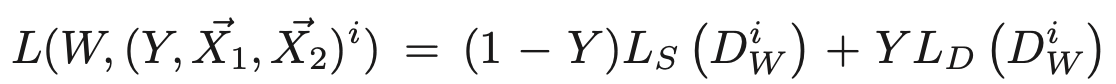

У contrastive loss тоже есть недостаток: его достаточно сложно настроить (подобрать к нему гиперпараметры).

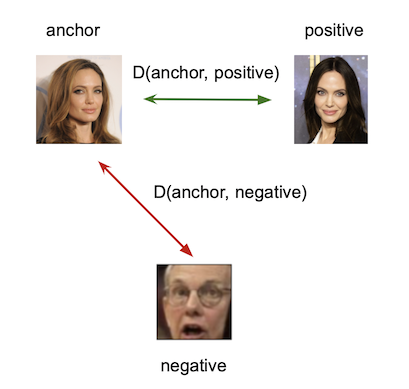

Вот так устроен пайплайн распознавания лиц, который мы хотим получить. Заметим, что все три части пайплайна обучаются отдельно.
- первая часть — это просто задача детекции;
- вторая часть — задача выравнивания фотографии лица;
- третья часть — задача распознавания лица по выровненной фотографии.

**Сбор и подготовка данных**

In [1]:
import pandas as pd
import os
import shutil

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! unzip drive/MyDrive/'celebA_train_500.zip' -d celebA_train_500

Streaming output truncated to the last 5000 lines.
  inflating: celebA_train_500/celebA_train_500/celebA_imgs/049159.jpg  
  inflating: celebA_train_500/__MACOSX/celebA_train_500/celebA_imgs/._049159.jpg  
  inflating: celebA_train_500/celebA_train_500/celebA_imgs/105435.jpg  
  inflating: celebA_train_500/__MACOSX/celebA_train_500/celebA_imgs/._105435.jpg  
  inflating: celebA_train_500/celebA_train_500/celebA_imgs/068197.jpg  
  inflating: celebA_train_500/__MACOSX/celebA_train_500/celebA_imgs/._068197.jpg  
  inflating: celebA_train_500/celebA_train_500/celebA_imgs/092985.jpg  
  inflating: celebA_train_500/__MACOSX/celebA_train_500/celebA_imgs/._092985.jpg  
  inflating: celebA_train_500/celebA_train_500/celebA_imgs/057367.jpg  
  inflating: celebA_train_500/__MACOSX/celebA_train_500/celebA_imgs/._057367.jpg  
  inflating: celebA_train_500/celebA_train_500/celebA_imgs/097625.jpg  
  inflating: celebA_train_500/__MACOSX/celebA_train_500/celebA_imgs/._097625.jpg  
  inflating: celebA

In [4]:
!ls celebA_train_500

celebA_train_500  __MACOSX


В зависимости от того, как заархивировались данные, возможно надо будет изменить следующую ячейку, так как у меня появилась вторая папка ненужная при архивации.

In [5]:
os.rename('celebA_train_500', 'to_delete')
shutil.move("to_delete/celebA_train_500", "celebA_train_500")

'celebA_train_500'

In [6]:
shutil.rmtree('to_delete')

Теперь воспользуемся таблицей для разделения на тренировочные, тестовые и валидационные данные. Создадим папки и переместим туда соответствующие фото.

In [7]:
train_test_split_df = pd.read_csv('celebA_train_500/celebA_train_split.txt', header=None, sep=" ")
train_test_split_df.columns = ['filename', 'datafolder']
train_test_split_df.head(2)

filename  datafolder
0  000001.jpg           0
1  000404.jpg           0

In [8]:
folders_dict = {0: 'train', 1: 'val', 2: 'test'}

In [9]:
os.mkdir(f'celebA_data')
for folder in folders_dict.values():
    os.mkdir(f'celebA_data/{folder}')

In [10]:
for row_num in range(len(train_test_split_df)):
    shutil.move(f"celebA_train_500/celebA_imgs/{train_test_split_df.at[row_num, 'filename']}", f"celebA_data/{folders_dict[train_test_split_df.at[row_num, 'datafolder']]}/{train_test_split_df.at[row_num, 'filename']}")

In [11]:
shutil.move("celebA_train_500/celebA_anno.txt", "celebA_anno.txt")

'celebA_anno.txt'

Воспользуемся таблицей с определением фото к классу и разделим все фото на подпапки.

In [12]:
annotations_df = pd.read_csv('celebA_anno.txt', header=None, sep=" ")
annotations_df.columns = ['filename', 'label']
annotations_df.head(2)

filename  label
0  000001.jpg      0
1  000404.jpg      0

In [13]:
for folder in folders_dict.values():
    for filename in os.listdir(f'celebA_data/{folder}'):
        if os.path.isfile(f"celebA_data/{folder}/{filename}"):
            subfolder_name = f"face_{annotations_df.loc[annotations_df['filename']==filename, 'label'].values[0]}"
            if not os.path.isdir(f"celebA_data/{folder}/{subfolder_name}"):
                os.mkdir(f"celebA_data/{folder}/{subfolder_name}")
            shutil.move(f"celebA_data/{folder}/{filename}", f"celebA_data/{folder}/{subfolder_name}/{filename}")

In [14]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
import random

Создадим класс для нашего датасета. Переопределим две функции: длины и выбора айтема. Так как мы будем использовать contrastive loss, то нам нужно, чтобы айтем был списком из двух фото и лэйблом, который обозначал их принадлежность к одному классу.

In [15]:
class CustomDataset(Dataset):
    def __init__(self, folder_name, transform):
      self.folder = folder_name
      self.transform = transform

      images, ids = list(zip(*self.folder.imgs))
      self.df_labels = pd.DataFrame({'img':images, 'ids':ids})

    def __len__(self):
        return 2*len(self.folder.imgs)

    def __getitem__(self, ind):
        same_class = random.randint(0,1)
        if same_class:
            img_id = random.choice(self.df_labels.ids.unique())
            df = self.df_labels[self.df_labels.ids==img_id].sample(2, replace=True).reset_index(drop = True)
        else:
            img1_id, img2_id = random.sample(self.df_labels.ids.unique().tolist(),2)
            df1 = self.df_labels[self.df_labels.ids==img1_id].sample(1)
            df2 = self.df_labels[self.df_labels.ids==img2_id].sample(1)
            df = pd.concat([df1, df2]).reset_index(drop = True)

        img1 = Image.open(df.iloc[0].img).convert("RGB")
        img2 = Image.open(df.iloc[1].img).convert("RGB")

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return (df.iloc[0].img,img1), (df.iloc[1].img,img2) , torch.from_numpy(np.array(1-int(same_class),dtype=np.float32))

In [16]:
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize(
                                mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])])
train_folder_name = datasets.ImageFolder('celebA_data/train')

Заведем две функции для быстрой подготовки фото (прогонки через трансформацию) и для визуализации фото.

In [17]:
def image_prepare(img_path, transform=None):
    img = Image.open(img_path).convert("RGB")
    if transform:
        img = transform(img)
    return img
def show_image(img,text=None):
    npimg = np.asarray(img)#.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(npimg)
    plt.show()

In [18]:
train_dataset = CustomDataset(train_folder_name, transform)
train_dataloader = DataLoader(train_dataset,
                        shuffle=True,
                        pin_memory=False,
                        num_workers=0,
                        batch_size=64)

In [19]:
val_folder_name = datasets.ImageFolder('celebA_data/val')
val_dataset = CustomDataset(val_folder_name, transform)
val_dataloader = DataLoader(val_dataset,
                        shuffle=False,
                        pin_memory=False,
                        num_workers=0,
                        batch_size=10)

In [20]:
test_folder_name = datasets.ImageFolder('celebA_data/test')
test_dataset = CustomDataset(test_folder_name, transform)
test_dataloader = DataLoader(test_dataset,
                        shuffle=False,
                        pin_memory=False,
                        num_workers=0,
                        batch_size=1)

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
device

device(type='cuda')

**ResNet модель и ее дообучение на датасете лиц**

В качестве модели возьмем ResNet50, обученную на классификацию изображений, мы забираем и замораживаем ее слои, а в качестве последнего слоя создаем свой, линейный, с выходным количеством параметров в 500 - число классов. Так же заранее создаем еще один вариант последнего слоя, когда нам нужны будут логиты для другого лосса (acr loss, который к сожалению не удался). И три метода прохода фото (или нескольких фото) для различных видов лосса.

In [23]:
from transformers import ResNetForImageClassification
import torch.nn as nn
import torch.nn.functional as F
import sklearn.metrics
from torch import optim
import torchvision

In [24]:
class ContrastiveLoss(nn.Module):
    def __init__(self):
        super(ContrastiveLoss, self).__init__()
    def forward(self, input1, input2, label, margin):
        e_dist = F.pairwise_distance(input1, input2, keepdim = False)
        loss = torch.mean((1-label) * torch.pow(e_dist, 2) + (label) * torch.pow(torch.clamp(margin - e_dist, min=0.0), 2))
        return loss

In [25]:
class ResNetModel4FaceRecognition(nn.Module):
  def __init__(self, resnet_model_stages=3, fc_dim=500, out_dim = 32, num_classes=500):
    super(ResNetModel4FaceRecognition, self).__init__()
    resnet_cnn = ResNetForImageClassification.from_pretrained("microsoft/resnet-50").resnet
    self.pretrained_cnn = nn.Sequential(*([resnet_cnn.embedder]+[resnet_cnn.encoder.stages[s] for s in range(3)]))
    for param in self.pretrained_cnn.parameters():
      param.requires_grad_(False)
    self.cnn_model = nn.Sequential(self.pretrained_cnn, nn.Sequential(*[resnet_cnn.encoder.stages[3].layers[0], nn.AdaptiveAvgPool2d(output_size=(1, 1))]))
    self.fc = nn.Sequential(
            nn.Linear(2048, 500),
            nn.ReLU(inplace=True),
            nn.Linear(500, 500),
            nn.ReLU(inplace=True),
            nn.Linear(500, 32))
    self.fc_logits = nn.Sequential(
            nn.Linear(2048, 500),
            nn.ReLU(inplace=True),
            nn.Linear(500, 32),
            nn.ReLU(inplace=True),
            nn.utils.weight_norm(nn.Linear(32, num_classes, bias=False), name='weight', dim=1))
  def forward_one(self, input, return_logits=False):
    output = self.cnn_model(input)
    output = output.view(output.size()[0], -1)
    if return_logits:
        output = self.fc_logits(output)
    else:
        output = self.fc(output)
    return output
  def forward(self, input1, input2):
    output1 = self.forward_one(input1)
    output2 = self.forward_one(input2)
    return output1, output2
  def forward_triplet(self, input1, input2, input3):
    output1 = self.forward_one(input1)
    output2 = self.forward_one(input2)
    output3 = self.forward_one(input3)
    return output1, output2, output3

In [ ]:
model = ResNetModel4FaceRecognition().to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/103M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [ ]:
model

ResNetModel4FaceRecognition(
  (pretrained_cnn): Sequential(
    (0): ResNetEmbeddings(
      (embedder): ResNetConvLayer(
        (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU()
      )
      (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (1): ResNetStage(
      (layers): Sequential(
        (0): ResNetBottleNeckLayer(
          (shortcut): ResNetShortCut(
            (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (normalization): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (layer): Sequential(
            (0): ResNetConvLayer(
              (convolution): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (normalization): BatchNorm2d(64,

In [ ]:
#model.load_state_dict(torch.load('models/epochs_n.pth'))

**Model Training**

In [26]:
os.mkdir('models')

In [ ]:
os.mkdir('models/contrastive_loss')

In [ ]:
criterion = ContrastiveLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10)

In [ ]:
margin=2
for epoch in range(70):
    epoch_loss = 0
    eval_loss = 0
    model.train()
    for i, data in enumerate(train_dataloader):
        (_,img1), (_,img2), label = data
        img1, img2, label = img1.to(device), img2.to(device) , label.to(device)
        optimizer.zero_grad()
        output1, output2 = model(img1, img2)
        loss = criterion(output1, output2, label, margin)
        loss.backward()
        optimizer.step()
        scheduler.step(loss)

        epoch_loss += loss.item()
    print(f"Epoch: {epoch+1}; Train loss: {epoch_loss/len(train_dataloader):.6f}")

    if (epoch+1) %10 == 0 :
        torch.save(model.state_dict(), 'models/contrastive_loss/epochs_' + str(epoch+1) + '.pth')
        model.eval()
        for i, data in enumerate(val_dataloader):
            (_,img1), (_,img2), label = data
            img1, img2, label = img1.to(device), img2.to(device) , label.to(device)
            optimizer.zero_grad()
            output1, output2 = model(img1, img2)
            loss = criterion(output1, output2, label, margin)
            eval_loss += loss.item()
        eval_loss = eval_loss/len(val_dataloader)
        print(f"Epoch: {epoch+1}; Val loss: {eval_loss/len(train_dataloader):.6f}")

Epoch: 1; Train loss: 0.702908
Epoch: 2; Train loss: 0.682895
Epoch: 3; Train loss: 0.674384
Epoch: 4; Train loss: 0.680103
Epoch: 5; Train loss: 0.669216
Epoch: 6; Train loss: 0.670173
Epoch: 7; Train loss: 0.678227
Epoch: 8; Train loss: 0.664205
Epoch: 9; Train loss: 0.667538
Epoch: 10; Train loss: 0.667576
Epoch: 10; Val loss: 0.002213
Epoch: 11; Train loss: 0.665585
Epoch: 12; Train loss: 0.659399
Epoch: 13; Train loss: 0.666392
Epoch: 14; Train loss: 0.666783
Epoch: 15; Train loss: 0.668446
Epoch: 16; Train loss: 0.664754
Epoch: 17; Train loss: 0.669268
Epoch: 18; Train loss: 0.669560
Epoch: 19; Train loss: 0.664540
Epoch: 20; Train loss: 0.658904
Epoch: 20; Val loss: 0.002223
Epoch: 21; Train loss: 0.676051


KeyboardInterrupt: 

In [ ]:
optimizer = optim.Adam(model.parameters(),lr = 0.000001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10)

In [ ]:
margin=2
for epoch in range(21, 41):
    epoch_loss = 0
    eval_loss = 0
    model.train()
    for i, data in enumerate(train_dataloader):
        (_,img1), (_,img2), label = data
        img1, img2, label = img1.to(device), img2.to(device) , label.to(device)
        optimizer.zero_grad()
        output1, output2 = model(img1, img2)
        loss = criterion(output1, output2, label, margin)
        loss.backward()
        optimizer.step()
        scheduler.step(loss)

        epoch_loss += loss.item()
    print(f"Epoch: {epoch+1}; Train loss: {epoch_loss/len(train_dataloader):.6f}")

    if (epoch+1) %10 == 0 :
        torch.save(model.state_dict(), 'models/contrastive_loss/epochs_' + str(epoch+1) + '.pth')
        model.eval()
        for i, data in enumerate(val_dataloader):
            (_,img1), (_,img2), label = data
            img1, img2, label = img1.to(device), img2.to(device) , label.to(device)
            optimizer.zero_grad()
            output1, output2 = model(img1, img2)
            loss = criterion(output1, output2, label, margin)
            eval_loss += loss.item()
        eval_loss = eval_loss/len(val_dataloader)
        print(f"Epoch: {epoch+1}; Val loss: {eval_loss/len(train_dataloader):.6f}")

Epoch: 22; Train loss: 0.671820
Epoch: 23; Train loss: 0.662221
Epoch: 24; Train loss: 0.652821
Epoch: 25; Train loss: 0.664945
Epoch: 26; Train loss: 0.666661
Epoch: 27; Train loss: 0.661355
Epoch: 28; Train loss: 0.664106
Epoch: 29; Train loss: 0.653852
Epoch: 30; Train loss: 0.650026
Epoch: 30; Val loss: 0.002120


KeyboardInterrupt: 

Valid loss можно показаться достаточно странно малым, но иногда в классе присутствует только одна фотография, из-за чего в его лоадере добавлено replace=True, из-за чего на одинаковых фото дистанция будет 0. Но далее мы посмотрим на точность на тестовой выборке, чтобы более точно понять, насколько хорошо модель работает.

Все модели находятся в соответствующих папках, чтобы можно было проверить их в использовании без обучение заново по скрипту.

In [ ]:
# model = ResNetModel4FaceRecognition().to(device)
#model.load_state_dict(torch.load('models/contrastive_loss/epochs_.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
# torch.save(model.state_dict(), 'models/contrastive_loss/epochs_.pth')

In [ ]:
# torch.save(criterion.state_dict(), 'models/contrastive_loss/learned_loss.pth')

**Evaluation**

Теперь визуализируем результат полученной модели, возьмем фото из определенного класса и будем выводить для него фото из того же и из других классов, и по дистанции между эмбедингами из модели определять, насколько похожи изображения по мнению модели. Чем больше значение дистанции, тем менее похожи фото.

In [ ]:
model.eval()

ResNetModel4FaceRecognition(
  (pretrained_cnn): Sequential(
    (0): ResNetEmbeddings(
      (embedder): ResNetConvLayer(
        (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU()
      )
      (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (1): ResNetStage(
      (layers): Sequential(
        (0): ResNetBottleNeckLayer(
          (shortcut): ResNetShortCut(
            (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (normalization): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (layer): Sequential(
            (0): ResNetConvLayer(
              (convolution): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (normalization): BatchNorm2d(64,

In [ ]:
model = model.to(device)

In [ ]:
num_same = 3
num_diff = 6
images, ids = list(zip(*test_folder_name.imgs))
df = pd.DataFrame({'img':images, 'ids':ids})
img0 = df.sample(1)

In [ ]:
test_id = img0.iloc[0].ids
test_img = img0.iloc[0].img

In [ ]:
df_test = pd.concat([df[df.ids == test_id].sample(num_same, replace=True), df[df.ids != test_id].sample(num_diff, replace=True)])

In [ ]:
im0 = image_prepare(test_img, transform=transform)[None, :]

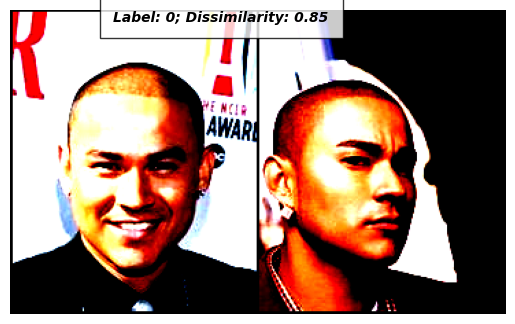

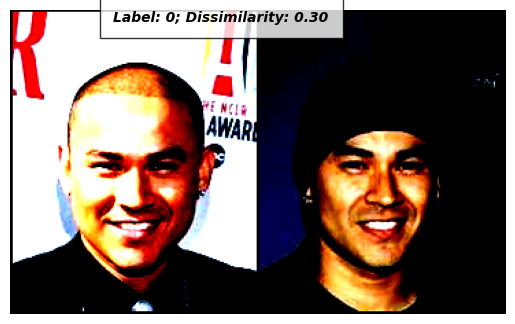

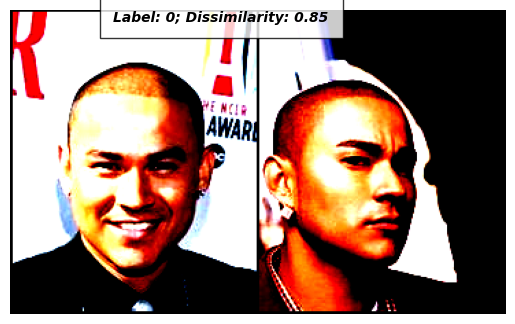

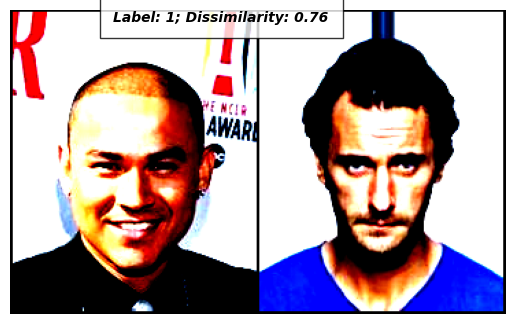

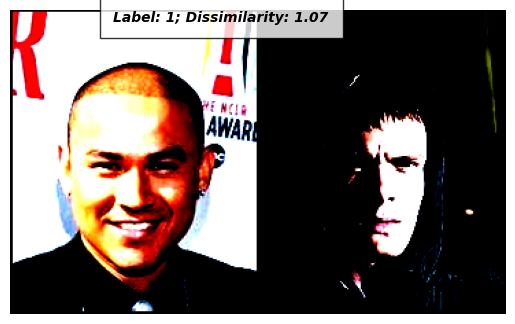

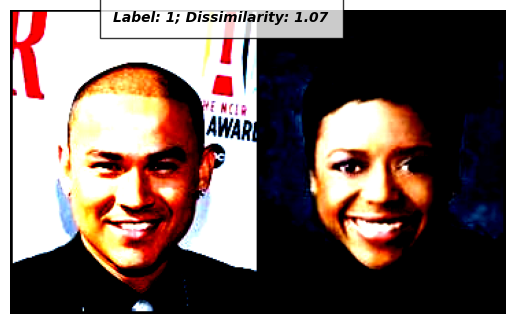

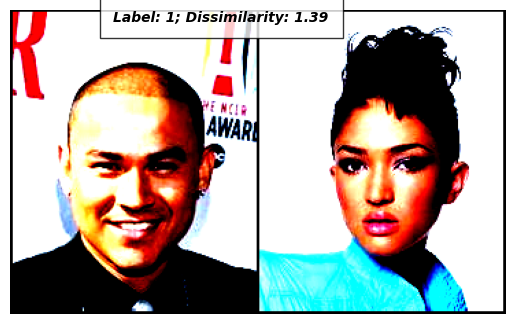

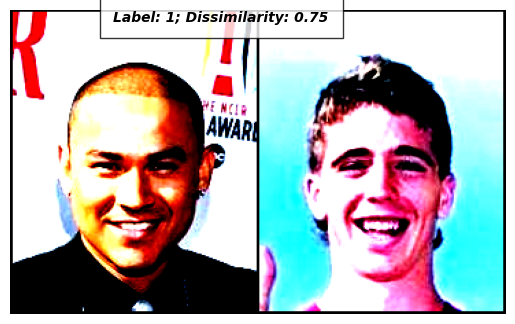

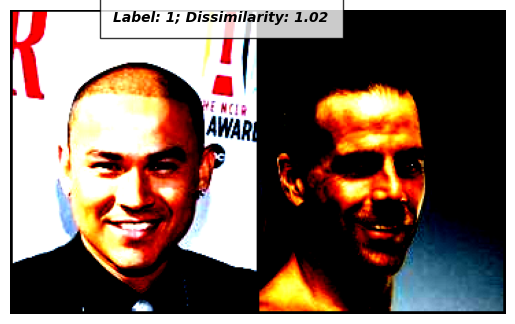

In [ ]:
for i in range(len(df_test)):
    im1 = image_prepare(df_test.iloc[i].img, transform=transform)[None, :]
    label = torch.tensor([int(df_test.iloc[i].ids != test_id)]).to(device)

    concatenated = torch.cat((im0,im1),0)

    output1,output2 = model(im0.to(device),im1.to(device))
    euclidean_distance = F.pairwise_distance(output1, output2)
    show_image(torchvision.utils.make_grid(concatenated).permute(1,2,0),f'Label: {label[0].item()}; Dissimilarity: {euclidean_distance.item():.2f}')

**Test Loss and Accuracy**

На тестовой выборке посчитаем точность модели.

In [ ]:
total_loss = 0
criterion = ContrastiveLoss()
euc_dist, labels = [], []
with torch.no_grad():
    for data in test_dataloader:
        (_,img1), (_,img2), label = data
        img1, img2 , label = img1.to(device), img2.to(device) , label.to(device)
        output1,output2 = model(img1,img2)
        loss = criterion(output1,output2,label, 2)
        total_loss += loss.item()

        e_dist = F.pairwise_distance(output1, output2)
        euc_dist.append(e_dist.detach().clone().cpu().numpy())
        labels.append(label.detach().clone().cpu().numpy())

print("loss: {:.2f}".format(total_loss/len(test_dataloader)))

In [ ]:
y_true, probs = np.concatenate(labels, axis=0), np.concatenate(euc_dist, axis=0)

In [ ]:
_, _, thresholds = sklearn.metrics.roc_curve(y_true, probs)
accuracy_scores = []
for thresh in thresholds:
    accuracy_scores.append(sklearn.metrics.accuracy_score(y_true, [m > thresh for m in probs]))
accuracies = np.array(accuracy_scores)
max_accuracy = accuracies.max()

In [ ]:
average_accuracy = accuracies.mean()
average_accuracy

0.7476084547637666

In [ ]:
max_accuracy

0.7853996224040277

Модель достигает точности выше 0.7 (средняя 0.747 и максимальная 0.785).
Так же после проверки еще одного лосса мы проверим обе получившиеся модели с помощью метрики identification rate, чтобы выделить наиболее удачный лосс для модели.

### Метрика качества для 3 части пайплайна

При обучении модели для распознавания лиц с помощью CE (кросс-энтропии) мы можем считать метрику accuracy как индикатор того, насколько хорошо наша модель работает. Но у accuracy тут есть недостаток: она не сможет померить, насколько хорошо наша модель работает на лицах людей, которых нет в обучающей выборке.  

Чтобы это исправить, придумали новую метрику: **identification rate**. Вот как она работает:

Создадим два набора изображений лиц: query и distractors. Никакие лица из этих наборов не должны содержаться в обучающем и валидационном датасете.

1. посчитаем косинусные расстояния между лицами, соответствующими одним и тем же людям из query части. Например, пусть одному человеку соответствуют три фото в query: 01.jpg, 02.jpg, 03.jpg. Тогда считаем три косинусных расстояния между всеми тремя парами из этих фото.
2. посчитаем косинусные расстояния между лицами, соответствующими разным людям из query части.
3. посчитаем косинусные расстояния между всеми парами лиц из query и distractors. Т.е. пара — это (лицо из query, лицо из distractors). Всего получится |query|*|distractors| пар.
4. Сложим количества пар, полученных на 2 и 3 шагах. Это количество false пар.
5. Зафиксируем **FPR** (false positive rate). Пусть, например, будет 0.01. FPR, умноженный на количество false пар из шага 4 — это разрешенное количество false positives, которые мы разрешаем нашей модели. Обозначим это количество через N.
6. Отсортируем все значения косинусных расстояний false пар. N — ое по счету значение расстояния зафиксируем как **пороговое расстояние**.
7. Посчитаем количество positive пар с шага 1, которые имеют косинусное расстояние меньше, чем пороговое расстояние. Поделим это количество на общее количество positive пар с шага 1. Это будет TPR (true positive rate) — итоговое значение нашей метрики.

Такая метрика обычно обозначается как TPR@FPR=0.01. FPR может быть разным. Приразных FPR будет получаться разное TPR.

Смысл этой метрики в том, что мы фиксируем вероятность ошибки вида false positive, т.е. когда "сеть сказала, что это один и тот же человек, но это не так", считаем порог косинусного расстояния для этого значения ошибки, потом берем все positive пары и смотрим, у скольких из них расстояние меньше этого порога. Т.е. насколько точно наша сеть ищет похожие лица при заданной вероятности ошибки вида false positive.

### Лосс-функции для 3 части пайплайна

Выше мы поняли, что нейросеть для распознавания лиц можно обучать разными способами. Два, которые мы упомянули — обучение сети на задачу классификации и с помощью contrastive loss. Давайте поговорим о том, какие лосс-функции мы можем использовать в том и в другом случае.



#### ArcFace Loss (Additive Angular Margin Loss)

В случае с обучением на задачу классификации лосс-функция, которая нам приходит в голову — Cross-Entropy. И на нее действительно можно обучать сеть для распознавания лиц. Но за много лет люди придумали более хитрые лосс-функции, которые делают обучение сети для распознавания лиц более эффективным. Одним из лучших считается ArcFace Loss (Additive Angular Margin Loss).

Этот лосс — чуть измененная кросс-энтропия. Он позволяет достичь лучшего распределения векторов лиц на сфере. В нем добавлены некоторые дополнительные ограничения и гиперпараметры, для того чтобы эмбеддинги лиц одного класса были более близки между собой, а эмбеддинги лиц разных людей оставались далеки. То есть, этот лосс позволяет лучше кластеризовать лица на сфере единичного радиуса.


**Как устроен ArcFace**:

Стандартные SoftMax + кросс-энтропия (CE) выглядят так:

$$L_{CE} = \frac{-1}{N}\sum_1^N \frac{e^{W_{y_i}^{T}x_i + b_{y_i}}}{\sum^n_{j=1}e^{W_j^Tx_i+b_j}},$$

здесь:
- $x_i \in \mathbb{R^d}$ — вектор $i$-го элемента обучающей выборки перед последним полносвязным слоем сети. $y_i$ — класс этого элемента;
- $W_j \in \mathbb{R^d}$ — j-ый столбец матрицы весов последнего слоя сети (т.е. слоя, который производит итоговую классификацю входящего объекта);
- $b_j \in \mathbb{R^d}$ — j-ый элемент вектора байеса последнего слоя сети;
- $N$ — batch size;
- $n$ — количество классов.


Хотя этот лосс работает хорошо, он явным образом не заставляет эмбеддинги $x_i$ элементов, принадлежащих одному классу, быть близкими друг к другу по расстоянию. И не заставляет эмбеддинги элементов, принадлежащих разным классам, быть далеко друг от друга. Все, что хочет этот лосс — чтобы на основе эмбеддингов $x_i$ можно было хорошо классифицировать элементы, никакие ограничений на расстояния между эмбеддингами $x_i$ он не вводит.

Из-за этого у нейросетей для распознавания лиц, которые обучены на обычном CE loss, бывают проблемы с распознаванием лиц, которые сильно отличаются от лиц того же человека разными допатрибутами (шляпа/прическа/очки и т.п.). Просто эмбеддинг для таких лиц получается довольно далек по расстоянию от других эмбеддингов лиц этого же человека.

Давайте теперь немного поправим формулу:
- уберем байес последнего слоя, т.е. сделаем $b_j=0$;
- нормализуем веса последнего слоя: ||$W_j$|| = 1;
- нормализуем эмбеддинги: ||$x_i$|| = 1. Перед подачей их на вход последнему слою (т.е. перед умножением на матрицу $W_j$) умножим их на гиперпараметр s. По сути, мы приводим норму всех эмбеддингов к s. Смысл этого гиперпараметра в том, что, возможно, сети проще будет классифицировать эмбеддинги, у которых не единичная норма.

Нормализация эмбеддингов приводит к тому, что эмбеддинги начинают быть распределены по сфере единичного радиуса (и сфере радиуса s после умножения на ниперпараметр s). И итоговые предсказания сети после последнего слоя зависят только от угла между эмбеддингами $x_i$ и выученных весов $W_j$. От нормы эмбеддинга $x_i$ они больше не зависят, т.к. у всех эмбеддингов они теперь одинаковые.

Получается, в степени экспоненты у нас останется выражение $s W_{y_i}^{T}x_i$, которое можно переписать в виде  $s W_{y_i}^{T}x_i = s ||W_{y_i}||\cdot ||x_i|| \cdot cos\Theta_{y_i}$. Тут $\Theta_{y_i}$ — это угод между векторами $W_{y_i}$ и $x_i$. Но так как мы сделали нормы $W_{y_i}$ и $x_i$ единичными, то все это выражение просто будет равно $s cos\Theta_{y_i}$.

В итоге мы получим следующую формулу лосса:

$$L = \frac{-1}{N}\sum_1^N \frac{e^{s\ cos\Theta_{y_i}}}{e^{s\ cos\Theta_{y_i}} + \sum^n_{j=1,\ j\ne y_i} e^{s\ cos\Theta_j}}$$


И последний шаг. Добавим еще один гиперпараметр $m$. Он называется additive angular margin penalty и заставляет эмбеддинги одного класса быть ближе друг к другу, а эмбеддинги разных классов — более далекими друг от друга.

В итоге получим вот что:

$$L_{ArcFace} = \frac{-1}{N}\sum_1^N \frac{e^{s\ cos(\Theta_{y_i} + m)}}{e^{s\ cos(\Theta_{y_i} + m)} + \sum^n_{j=1,\ j\ne y_i} e^{s\ cos\Theta_j}}$$

Это и есть ArcFace Loss с двумя  гиперпараметрами, s и m.

Получается, что ArcFace Loss завтавляет сеть выучивать эмбеддинги, распределенные по сфере радиуса s, причем чтобы эмбеддинги одного класса были ближе друг к другу, а эмбеддинги разных классов — более далеки друг от друга.



**Доплитература по ArcFace Loss:**

Оригинальная статья: https://arxiv.org/pdf/1801.07698.pdf

Репозиторий с кодом: https://github.com/deepinsight/insightface

#### Triplet Loss

Triplet Loss — это один из лоссов для contrastive learning. Чтобы учить модель с помощью этого лосса, модели не нужен последний классификационный слой. Этот лосс работает прямо с эмбеддингами $x_i$ элементов, которые выдает модель.

Снова скажем, что идея лосса — заставить эмбеддинги лиц одного человека быть более близкими по некоторому расстоянию, а эмбеддинги лиц разных людей — далекими друг от друга. Общая формула лосса выглядит так:

$$L(e, p, n) = max\{d(a, p) - d(a, n) + margin, 0\},$$

здесь
- $e$ — эмбеддинг входного лица (output модели)
- $p$ — "positive" эмбеддинг для входного лица (т.е. эмбеддинг такого элемента, что мы хотим, чтобы $e$ и $p$ были близки. В нашем случае это значит, что $e$ и $p$ должны быть выходами сети на два разных фото одного и того же человека).
- $n$ — "negative" эмбеддинг для входного лица (т.е. эмбеддинг такого элемента, что мы хотим, чтобы $e$ и $p$ были далеки. В нашем случае это значит, что $e$ и $p$ должны быть выходами сети на два разных фото разных людей).
- $d(x, y)$ — метрика расстояния между эмбеддингами, по которой мы их сравниваем.
- margin — гиперпараметр, который заставляет $d(a, p)$ и $d(a, n)$ быть еще дальше друг от друга.

**Эмбеддинги $e$, $p$ и $n$ нужно нормализовать, прежде чем подавать в лосс-функцию**.

У TripletLoss есть куча разных вариаций. В некоторых из них больше гиперпараметров, в других предлагают использовать больше одного позитивного и негативного эмбеддинга за раз. Где-то предлагается умный способ выбора negative эмбеддинга (например, выбирается такой, на котором нейросеть пока плохо работает, т.е. считает $e$ и $n$ близкими).

Пример реализации TripletLoss можно найти [здесь](https://pytorch.org/docs/stable/generated/torch.nn.TripletMarginWithDistanceLoss.html#torch.nn.TripletMarginWithDistanceLoss).

Будьте готовы, что TripletLoss придется настраивать, чтобы добиться хорошего результата при обучении сети.


**Что нужно учесть при реализации Triplet Loss**:
- при обучении мы обычно хотим следить за ходом обучения модели, считая какую-то метрику качества. Тут у нас больше нет классификационного слоя, так что accuracy мы считать не можем. Нужно придумать, как в случае Triplet Loss считать метрику качества на вализации в течение обучения. Подумайте, как можно это сделать?
- скорее всего, чтобы обучить сеть на Triplet Loss, придется написать кастомный Dalaset/Dataloader, который будет возвращать тройки элементов (anchor, positive, negative).
- не забудьте нормализовать эмбеддинги перед подсчетом лосса! Это можно сделать руками, а можно, например, добавить в конец сети batchnorm без обучаемых параметров.

**Доплитература по Triplet Loss**:

- Идея TripletLoss: https://en.wikipedia.org/wiki/Triplet_loss
- Хорошая статья про batch mining techniques для выбора positive и negative элементов: https://omoindrot.github.io/triplet-loss#triplet-mining
- Реализация TripletLoss в PyTorch : https://pytorch.org/docs/stable/generated/torch.nn.TripletMarginWithDistanceLoss.html#torch.nn.TripletMarginWithDistanceLoss
- Еще одна реализация TripletLoss: https://github.com/alfonmedela/triplet-loss-pytorch/blob/master/loss_functions/triplet_loss.py

In [39]:
class TripletLoss(nn.Module):
    def __init__(self, margin):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        distance_positive = (anchor - positive).pow(2).sum(1)
        distance_negative = (anchor - negative).pow(2).sum(1)
        losses = F.relu(distance_positive - distance_negative + self.margin)
        return losses.mean()

In [40]:
class CustomDataset(Dataset):
    def __init__(self, folder_name, transform):
      self.folder = folder_name
      self.transform = transform

      images, ids = list(zip(*self.folder.imgs))
      self.df_labels = pd.DataFrame({'img':images, 'ids':ids})

    def __len__(self):
        return 3*len(self.folder.imgs)

    def __getitem__(self, ind):
        imgs1_id, img2_id = random.sample(self.df_labels.ids.unique().tolist(),2)
        df1 = self.df_labels[self.df_labels.ids==imgs1_id].sample(2, replace=True)
        df2 = self.df_labels[self.df_labels.ids==img2_id].sample(1)
        df = pd.concat([df1, df2]).reset_index(drop = True)

        anchor = Image.open(df.iloc[0].img).convert("RGB")
        positive = Image.open(df.iloc[1].img).convert("RGB")
        negative = Image.open(df.iloc[2].img).convert("RGB")

        if self.transform:
            anchor = self.transform(anchor)
            positive = self.transform(positive)
            negative = self.transform(negative)

        return (df.iloc[0].img,anchor), (df.iloc[1].img,positive), (df.iloc[2].img,negative)

In [41]:
train_dataset = CustomDataset(train_folder_name, transform)
train_dataloader = DataLoader(train_dataset,
                        shuffle=True,
                        pin_memory=False,
                        num_workers=0,
                        batch_size=64)
val_dataset = CustomDataset(val_folder_name, transform)
val_dataloader = DataLoader(val_dataset,
                        shuffle=False,
                        pin_memory=False,
                        num_workers=0,
                        batch_size=64)
test_dataset = CustomDataset(test_folder_name, transform)
test_dataloader = DataLoader(test_dataset,
                        shuffle=False,
                        pin_memory=False,
                        num_workers=0,
                        batch_size=1)

**Model Training**

In [42]:
os.mkdir('models/triplet_loss')

In [43]:
model = ResNetModel4FaceRecognition().to(device)
criterion = TripletLoss(margin=2)
optimizer = optim.Adam(model.parameters(),lr = 0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [ ]:
for epoch in range(9, 31):
    epoch_loss = 0
    eval_loss = 0
    model.train()
    for i, data in enumerate(train_dataloader):
        (_,img1), (_,img2), (_, img3) = data
        img1, img2, img3 = img1.to(device), img2.to(device) , img3.to(device)
        optimizer.zero_grad()
        output1, output2, output3 = model.forward_triplet(img1, img2, img3)
        loss = criterion(output1, output2, output3)
        loss.backward()
        optimizer.step()
        scheduler.step(loss)

        epoch_loss += loss.item()
    print(f"Epoch: {epoch}; Train loss: {epoch_loss/len(train_dataloader):.6f}")

    if (epoch+1) %10 == 0 :
        model.eval()
        for i, data in enumerate(val_dataloader):
            (_,img1), (_,img2), (_,img3) = data
            img1, img2, img3 = img1.to(device), img2.to(device) , img3.to(device)
            optimizer.zero_grad()
            output1, output2, output3 = model.forward_triplet(img1, img2, img3)
            loss = criterion(output1, output2, output3)
            eval_loss += loss.item()
        eval_loss = eval_loss/len(val_dataloader)
        print(f"Epoch: {epoch}; Val loss: {eval_loss/len(train_dataloader):.6f}")

        torch.save(model.state_dict(), 'models/triplet_loss/epochs_' + str(epoch+1) + '.pth')

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 9; Train loss: 0.116912
Epoch: 9; Val loss: 0.000903
Epoch: 10; Train loss: 0.110279
Epoch: 11; Train loss: 0.115065
Epoch: 12; Train loss: 0.098702
Epoch: 13; Train loss: 0.093503
Epoch: 14; Train loss: 0.096858
Epoch: 15; Train loss: 0.086918
Epoch: 16; Train loss: 0.084580
Epoch: 17; Train loss: 0.081458
Epoch: 18; Train loss: 0.080650
Epoch: 19; Train loss: 0.078479
Epoch: 19; Val loss: 0.000925
Epoch: 20; Train loss: 0.076385
Epoch: 21; Train loss: 0.074618
Epoch: 22; Train loss: 0.071136


KeyboardInterrupt: 

In [46]:
model.load_state_dict(torch.load('./models/triplet_loss/epochs_20.pth'))

<All keys matched successfully>

In [47]:
total_loss = 0
criterion = TripletLoss(margin=2)
pos_scores, neg_scores = [], []
with torch.no_grad():
    for data in test_dataloader:
        (_,img1), (_,img2), (_, img3) = data
        img1, img2 , img3 = img1.to(device), img2.to(device) , img3.to(device)
        output1, output2, output3 = model.forward_triplet(img1, img2, img3)

        e_dist = F.pairwise_distance(output1, output2)
        pos_scores.append(e_dist.detach().clone().cpu().numpy())
        e_dist = F.pairwise_distance(output1, output3)
        neg_scores.append(e_dist.detach().clone().cpu().numpy())
accuracy = np.sum(np.array(pos_scores) < np.array(neg_scores)) / len(pos_scores)

In [48]:
accuracy

0.9421019509125236

С Triplet Loss у нас получилось еще большая точность в 0.942 на тестовой выборке.

#### Другие лосс-функции

Кроме ArcFace и Triplet Loss, есть еще много разных вариантов лоссов для задачи face recognition. Некоторые из них можно найти, например, [тут](https://openaccess.thecvf.com/content_CVPRW_2020/papers/w48/Hsu_A_Comprehensive_Study_on_Loss_Functions_for_Cross-Factor_Face_Recognition_CVPRW_2020_paper.pdf). Вы можете попробовать реализовать другие лосс-функции в этом проекте.

Кроме этого, можно миксовать лосс-функции. Например, обучать нейросеть на сумме ArcFace и TripletLoss. Часто так выходит лучше, чем если обучать на каком-то одном лоссе.

## Задача проекта

В целом, **задача проекта — реализовать один или несколько частей системы распознавания лиц**. Вот что можно делать:

- **(2 балла, обязательная часть!) Обучить нейросеть для 3 части пайплайна (распознавание лиц) на CE loss. Для этого можно использовать нейросети, предобученные на ImageNet. Нельзя брать нейросети, которые уже предобучены на распознавание лиц! Добиться достаточного качества классификации**.
- (2 балла) Обучить нейросеть для поиска ключевых точек лица и написать код, который принимает на вход фотографию лица и возвращает выровненное лицо на основе найденных точек (т.е. реализовать вторую часть пайплайна face recognition);
- (2 балла) Собрать весь пайплайн распознавания лиц. Этому пайплайну должно быть можно подать на вход картинку с лицами, и пайплайн должен возвращать эмбеддинги всех найденных лиц. Хорошо будет продемонстрировать работу вашего пайплайна на паре лиц одинаковых и разных людей с подсчетом метрики расстояния между их эмбеддингами. В пайплайне можно использовать предобученную сеть для детекции лиц, или же обучить свою;
- **(2 балла) Реализовать Identification Rate Metric (ниже дан щаблон кода для него и ячейки для тестирования)**;
- (2 балла) Реализовать ArcFace loss, обучить сеть с нуля на нем. Добиться достаточного качества классификации;
- **(2 балла) Реализовать Triplet loss, обучить сеть с нуля на нем. Добиться достаточного качества классификации**;
- (1 балл) Обучить сеть на смеси ArcFace loss и Triplet loss. Добиться достаточного качества классификации;
- (2 балла) Исследовать литературу, статьи по Face Recognition, написать literature review с обзором современных методов, улучшений сети и пайплайна.
- (2 балла) Исследовать пространство полученных эмбеддингов. Например, как в случае Arcface Loss расположены эмбеддинги на сфере? Где расположены эмбеддинги картинок-аутлаеров? (например, если лицо на картинке сильно смазано или почти не видно. Или это вообще не картинка лица). Как еще можно исследовать модель?
- Улучшить сеть с помощью разных трюков. Например, попробовать другие лосс-функции, поискать статьи с разными улучшениями и попробовать что-то закодить. Баллы тут зависят от сложности улучшения и вашей иреализации.

Пожалуйста, пишите подробные комментарии к своему коду. Вставляйте ссылки на статьи, где нашли какие-то трюки. Объясняйте, почему реализовали что-то именно так. Будет классно, если вы опишете свой путь в экспериментах при работе с оубчением модели или Triplet Loss.


**Данные. Какие данные можно использовать для выполнения проекта:**

Для третьей части пайплайна (нейросети для распознавания лиц) есть такие варианты:
- Я подготовила данные лиц 500 людей CelebA-500. Они уже выровнены. Скачать можно тут: https://disk.yandex.ru/d/S8f03spLIA1wrw
    Внутри:
        - celebA_imgs — папка с выровненными картинками;
        - celebA_anno.txt — файл с аннотацией — каждой картинке из celebA_imgs поставлен в соответствие ее id;
        - celebA_train_split.txt — файл со сплитом на train/val/test.
    Эти данные — часть открытого датасета [CelebA](https://colab.research.google.com/corgiredirector?site=https%3A%2F%2Fmmlab.ie.cuhk.edu.hk%2Fprojects%2FCelebA.html), который один из стандартных для обучения моделей, связанных с лицами.
- Использовать любые другие данные. Например, можно взять больше картинок из [CelebA](https://colab.research.google.com/corgiredirector?site=https%3A%2F%2Fmmlab.ie.cuhk.edu.hk%2Fprojects%2FCelebA.html). Или вот еще один популярный датасет: [LFW](https://colab.research.google.com/corgiredirector?site=http%3A%2F%2Fvis-www.cs.umass.edu%2Flfw%2F). Обращайте внимание на то, выровнены ли лица в том датасете, который вы скачиваете, и кропайте картинки так, чтобы на них оставалось преимущественно лицо.


Может быть удобно сначала проверить вашу сеть на данных CelebA-500, а затем переходить к ее обучению на большем датасете.

Для обучения других частей пайплайна данные нужно выбрать самим. Разные части пайплайна можно обучать на разных данных. Но нужно, чтобы затем весь пайплайн хорошо работал на новых лицах.

- Для тестирования кода Identification Rate Metric я также подготовила данные из CelebA, которые выровнены точно так же, как картинки из CelebA-500. Если вы обучили нейросеть на датасете CelebA-500, можете ее тестировать с помощью этих данных. Ссылка на них есть в разделе "шаблон кода для Identification Rate Metric" ниже в ноутбуке.



**Проект оценивается из 10 баллов. Чтобы проект считался сданным, нужно набрать 5 или более баллов.**  Можно выполнять любые части проекта, которые описаны выше, баллы будут суммироваться. Единственная обязательная часть — обучение сети с нуля на CE loss.

Самый простой (на мой взгляд) набрать 6 баллов:
- (2 балла) Обучить нейросеть для распознавания лиц на датасете CelebA-500. Чтобы получить два балла, нужно добиться accuracy на тестовой части >0.7;
- (2 балла) Реализовать Identification Rate Metric, протестировать ее на предоставленных данных;
- (2 балла) Реализовать ArcFace loss, обучить сеть с нуля на нем. Добиться accuracy на тестовой части >0.7;



## Шаблон кода для Identificaton rate metric (TPR@FPR)

**Данные**. Если вы обучали нейросеть для распознавания лиц на данных, предложенных в этом ноутбуке (CelebA-500), то для подсчета метрики вы можете воспользоваться данными, которые лежат по этой ссылке: https://disk.yandex.com/d/KN4EEkNKrF_ZXQ. Эти данные уже разбиты на query и distractors, и в отдельном файле также находится информация о классах для картинок из query. Эти картинки заалайнены точно так же, как картинки из обучающей выборки CelebA-500

Если вы обучали нейросеть на других данных, то вам нужно сделать данные для тестирования самому. Делается это примерно так:
- Выбраете несколько id, которые не использовались при тренировке моделей, и помещаете их в query set;
- Выбираете несколько id, которые не использовались при тренировке моделей и не входят в query, и помещаете их в distractors set. Обычно distractors set должен быть сильно больше, чем query set.
- Обрабатываете картинки из query и distractors тем же способом, что картинки для обучения сети.


Обратите внимание, что если картинок в query и distractors очень много, то полученных пар картинок в пунктах 1-2-3 алгоритма подсчета TPR@FPR будет очень-очень много. Чтобы код подсчета работал быстрее, ограничивайте размеры этих датасетов. Контролируйте, сколько значений расстояний вы считаете.

Ниже дан шаблон кода для реализации FPR@TPR метрики и ячейки с тестами. Тесты проверяют, что ваш код в ячейках написан правильно.

In [49]:
! unzip drive/MyDrive/'celebA_ir.zip' -d celebA_ir

Streaming output truncated to the last 5000 lines.
  inflating: celebA_ir/celebA_ir/celebA_distractors/137891.jpg  
  inflating: celebA_ir/__MACOSX/celebA_ir/celebA_distractors/._137891.jpg  
  inflating: celebA_ir/celebA_ir/celebA_distractors/012393.jpg  
  inflating: celebA_ir/__MACOSX/celebA_ir/celebA_distractors/._012393.jpg  
  inflating: celebA_ir/celebA_ir/celebA_distractors/116687.jpg  
  inflating: celebA_ir/__MACOSX/celebA_ir/celebA_distractors/._116687.jpg  
  inflating: celebA_ir/celebA_ir/celebA_distractors/139664.jpg  
  inflating: celebA_ir/__MACOSX/celebA_ir/celebA_distractors/._139664.jpg  
  inflating: celebA_ir/celebA_ir/celebA_distractors/029462.jpg  
  inflating: celebA_ir/__MACOSX/celebA_ir/celebA_distractors/._029462.jpg  
  inflating: celebA_ir/celebA_ir/celebA_distractors/132056.jpg  
  inflating: celebA_ir/__MACOSX/celebA_ir/celebA_distractors/._132056.jpg  
  inflating: celebA_ir/celebA_ir/celebA_distractors/092592.jpg  
  inflating: celebA_ir/__MACOSX/celebA

In [50]:
from numpy.linalg import norm

In [51]:
os.rename('celebA_ir', 'to_delete')
shutil.move("to_delete/celebA_ir", "celebA_ir")
shutil.rmtree('to_delete')

In [52]:
# Если вы работаете с данными, которые даны по ссылке,
# то эта ячейка поможет их загрузить
from collections import defaultdict

# file with query part annotations: which image belongs to which class
# format:
#     image_name_1.jpg 2678
#     image_name_2.jpg 2679
f = open('./celebA_ir/celebA_anno_query.csv', 'r')
query_lines = f.readlines()[1:]
f.close()
query_lines = [x.strip().split(',') for x in query_lines]
# plain list of image names from query. Neede to compute embeddings for query
query_img_names = [x[0] for x in query_lines]

# dictionary with info of which images from query belong to which class
# format:
#     {class: [image_1, image_2, ...]}
query_dict = defaultdict(list)
for img_name, img_class in query_lines:
  query_dict[img_class].append(img_name)

# list of distractor images
distractors_img_names = os.listdir('./celebA_ir/celebA_distractors')

In [53]:
def compute_embeddings(model, images_list, query):
  '''
  compute embeddings from the trained model for list of images.
  params:
    model: trained nn model that takes images and outputs embeddings
    images_list: list of images paths to compute embeddings for
  output:
    list: list of model embeddings. Each embedding corresponds to images
          names from images_list
  '''
  if query:
      add_path = './celebA_ir/celebA_query/'
  else:
    add_path = './celebA_ir/celebA_distractors/'
  emb_list = []
  for img in images_list:
      img = image_prepare(add_path + img, transform=transform)[None, :]
      with torch.no_grad():
          model.eval()
          emb_list.append(model.forward_one(img.to(device)).flatten().cpu().numpy())
  return emb_list

In [73]:
model = ResNetModel4FaceRecognition().to(device)
model.load_state_dict(torch.load('./models/contrastive_loss/epochs_30.pth'))

/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


<All keys matched successfully>

In [74]:
query_embeddings = compute_embeddings(model, query_img_names, query=True)
distractors_embeddings = compute_embeddings(model, distractors_img_names, query=False)

In [54]:
def compute_cosine_query_pos(query_dict, query_img_names, query_embeddings):
  '''
  compute cosine similarities between positive pairs from query (stage 1)
  params:
    query_dict: dict {class: [image_name_1, image_name_2, ...]}. Key: class in
                the dataset. Value: images corresponding to that class
    query_img_names: list of images names
    query_embeddings: list of embeddings corresponding to query_img_names
  output:
    list of floats: similarities between embeddings corresponding
                    to the same people from query list
  '''
  sim_list = []
  for class_img in query_dict.keys():
      ind = [i for i in range(len(query_img_names)) for elem in query_dict[class_img] if elem==query_img_names[i]]
      emb = np.array(query_embeddings)[ind]
      for i, e in enumerate(emb):
          for j in range(i+1, len(emb)):
              sim = np.dot(e, emb[j])/(norm(e)*norm(emb[j]))
              sim_list.append(sim)
  return sim_list

def compute_cosine_query_neg(query_dict, query_img_names, query_embeddings):
  '''
  compute cosine similarities between negative pairs from query (stage 2)
  params:
    query_dict: dict {class: [image_name_1, image_name_2, ...]}. Key: class in
                the dataset. Value: images corresponding to that class
    query_img_names: list of images names
    query_embeddings: list of embeddings corresponding to query_img_names
  output:
    list of floats: similarities between embeddings corresponding
                    to different people from query list
  '''
  sim_list, index_to_del = [], []
  for class_img in query_dict.keys():
      index_p = [i for i in range(len(query_img_names)) for el in query_dict[class_img] if el==query_img_names[i]]
      index_to_del.extend(index_p)
      emb_p = np.array(query_embeddings)[index_p]
      index_n = [i for i in range(len(query_img_names)) if i not in index_to_del]
      emb_n = np.array(query_embeddings)[index_n]
      for el_p in emb_p:
          for el_n in emb_n:
              sim = np.dot(el_p, el_n)/(norm(el_p)*norm(el_n))
              sim_list.append(sim)
  return sim_list

def compute_cosine_query_distractors(query_embeddings, distractors_embeddings):
  '''
  compute cosine similarities between negative pairs from query and distractors
  (stage 3)
  params:
    query_embeddings: list of embeddings corresponding to query_img_names
    distractors_embeddings: list of embeddings corresponding to distractors_img_names
  output:
    list of floats: similarities between pairs of people (q, d), where q is
                    embedding corresponding to photo from query, d —
                    embedding corresponding to photo from distractors
  '''
  sim_list = []
  for el_p in query_embeddings:
      for el_n in distractors_embeddings:
          sim = np.dot(el_p, el_n)/(norm(el_p)*norm(el_n))
          sim_list.append(sim)
  return sim_list

In [75]:
cosine_query_pos = compute_cosine_query_pos(query_dict, query_img_names,
                                            query_embeddings)
cosine_query_neg = compute_cosine_query_neg(query_dict, query_img_names,
                                            query_embeddings)
cosine_query_distractors = compute_cosine_query_distractors(query_embeddings,
                                                            distractors_embeddings)


Ячейка ниже проверяет, что код работает верно:

In [76]:
test_query_dict = {
    2876: ['1.jpg', '2.jpg', '3.jpg'],
    5674: ['5.jpg'],
    864:  ['9.jpg', '10.jpg'],
}
test_query_img_names = ['1.jpg', '2.jpg', '3.jpg', '5.jpg', '9.jpg', '10.jpg']
test_query_embeddings = [
                    [1.56, 6.45,  -7.68],
                    [-1.1 , 6.11,  -3.0],
                    [-0.06,-0.98,-1.29],
                    [8.56, 1.45,  1.11],
                    [0.7,  1.1,   -7.56],
                    [0.05, 0.9,   -2.56],
]

test_distractors_img_names = ['11.jpg', '12.jpg', '13.jpg', '14.jpg', '15.jpg']

test_distractors_embeddings = [
                    [0.12, -3.23, -5.55],
                    [-1,   -0.01, 1.22],
                    [0.06, -0.23, 1.34],
                    [-6.6, 1.45,  -1.45],
                    [0.89,  1.98, 1.45],
]

test_cosine_query_pos = compute_cosine_query_pos(test_query_dict, test_query_img_names,
                                            test_query_embeddings)
test_cosine_query_neg = compute_cosine_query_neg(test_query_dict, test_query_img_names,
                                            test_query_embeddings)
test_cosine_query_distractors = compute_cosine_query_distractors(test_query_embeddings,
                                                            test_distractors_embeddings)

In [77]:
true_cosine_query_pos = [0.8678237233650096, 0.21226104378511604,
                         -0.18355866977496182, 0.9787437979250561]
assert np.allclose(sorted(test_cosine_query_pos), sorted(true_cosine_query_pos)), \
      "A mistake in compute_cosine_query_pos function"

true_cosine_query_neg = [0.15963231223161822, 0.8507997093616965, 0.9272761484302097,
                         -0.0643994061127092, 0.5412660901220571, 0.701307100338029,
                         -0.2372575528216902, 0.6941032794522218, 0.549425446066643,
                         -0.011982733001947084, -0.0466679194884999]
assert np.allclose(sorted(test_cosine_query_neg), sorted(true_cosine_query_neg)), \
      "A mistake in compute_cosine_query_neg function"

true_cosine_query_distractors = [0.3371426578637511, -0.6866465610863652, -0.8456563512871669,
                                 0.14530087113136106, 0.11410510307646118, -0.07265097629002357,
                                 -0.24097699660707042,-0.5851992679925766, 0.4295494455718534,
                                 0.37604478596058194, 0.9909483738948858, -0.5881093317868022,
                                 -0.6829712976642919, 0.07546364489032083, -0.9130970963915521,
                                 -0.17463101988684684, -0.5229363015558941, 0.1399896725311533,
                                 -0.9258034013399499, 0.5295114163723346, 0.7811585442749943,
                                 -0.8208760031249596, -0.9905139680301821, 0.14969764653247228,
                                 -0.40749654525418444, 0.648660814944824, -0.7432584300096284,
                                 -0.9839696492435877, 0.2498741082804709, -0.2661183373780491]
assert np.allclose(sorted(test_cosine_query_distractors), sorted(true_cosine_query_distractors)), \
      "A mistake in compute_cosine_query_distractors function"

И, наконец, финальная функция, которая считает IR metric:

In [55]:
def compute_ir(cosine_query_pos, cosine_query_neg, cosine_query_distractors,
               fpr=0.1):
  '''
  compute identification rate using precomputer cosine similarities between pairs
  at given fpr
  params:
    cosine_query_pos: cosine similarities between positive pairs from query
    cosine_query_neg: cosine similarities between negative pairs from query
    cosine_query_distractors: cosine similarities between negative pairs
                              from query and distractors
    fpr: false positive rate at which to compute TPR
  output:
    float: threshold for given fpr
    float: TPR at given FPR
  '''
  neg_pairs = cosine_query_neg + cosine_query_distractors
  num = int(len(neg_pairs)*fpr)
  thr = sorted(neg_pairs, reverse=True)[num]
  final_list = [i for i in cosine_query_pos if i > thr]
  TPR = round(len(final_list)/len(cosine_query_pos),2)
  return thr, TPR

И ячейки для ее проверки:

In [78]:
test_thr = []
test_tpr = []
for fpr in [0.5, 0.3, 0.1]:
  x, y = compute_ir(test_cosine_query_pos, test_cosine_query_neg,
                    test_cosine_query_distractors, fpr=fpr)
  test_thr.append(x)
  test_tpr.append(y)

In [79]:
true_thr = [-0.011982733001947084, 0.3371426578637511, 0.701307100338029]
assert np.allclose(np.array(test_thr), np.array(true_thr)), "A mistake in computing threshold"

true_tpr = [0.75, 0.5, 0.5]
assert np.allclose(np.array(test_tpr), np.array(true_tpr)), "A mistake in computing tpr"

А в ячейке ниже вы можете посчитать TPR@FPR для датасета с лицами. Давайте, например, посчитаем для значений fpr = [0.5, 0.2, 0.1, 0.05].

**Model with contrastive loss**

In [80]:
thresholds, TPRs = dict(), dict()
for fpr in [0.5, 0.2, 0.1, 0.05]:
    thr, TPR = compute_ir(cosine_query_pos, cosine_query_neg, cosine_query_distractors, fpr=fpr)
    thresholds[f"fpr={fpr}"] = f"threshold={thr}"
    TPRs[f"fpr={fpr}"] = f"TPR={TPR}"

In [81]:
thresholds

{'fpr=0.5': 'threshold=0.6995633840560913',
 'fpr=0.2': 'threshold=0.8951513767242432',
 'fpr=0.1': 'threshold=0.940153956413269',
 'fpr=0.05': 'threshold=0.9619577527046204'}

In [82]:
TPRs

{'fpr=0.5': 'TPR=0.85',
 'fpr=0.2': 'TPR=0.49',
 'fpr=0.1': 'TPR=0.29',
 'fpr=0.05': 'TPR=0.17'}

In [83]:
df = pd.DataFrame(columns=['fpr', 'threshold', 'TPR'])
for i_num, i in enumerate(thresholds.keys()):
    df.at[i_num, 'fpr'] = i[4:]
    df.at[i_num, 'threshold'] = thresholds[i][10:]
    df.at[i_num, 'TPR'] = TPRs[i][4:]
df[['fpr', 'threshold', 'TPR']] = df[['fpr', 'threshold', 'TPR']].astype('float')

<Axes: xlabel='fpr'>

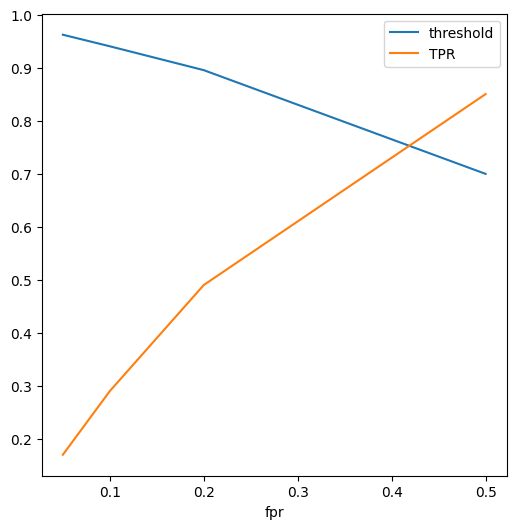

In [84]:
df.plot(x="fpr", y=["threshold", "TPR"], kind="line", figsize=(6, 6))

**Model with Triplet Loss**

In [ ]:
model = ResNetModel4FaceRecognition().to(device)
model.load_state_dict(torch.load('./models/triplet_loss/epochs_20.pth'))

In [56]:
query_embeddings = compute_embeddings(model, query_img_names, query=True)
distractors_embeddings = compute_embeddings(model, distractors_img_names, query=False)

In [57]:
cosine_query_pos = compute_cosine_query_pos(query_dict, query_img_names,
                                            query_embeddings)
cosine_query_neg = compute_cosine_query_neg(query_dict, query_img_names,
                                            query_embeddings)
cosine_query_distractors = compute_cosine_query_distractors(query_embeddings,
                                                            distractors_embeddings)

In [62]:
thresholds_triplet, TPRs_triplet = dict(), dict()
for fpr in [0.5, 0.2, 0.1, 0.05]:
    thr, TPR = compute_ir(cosine_query_pos, cosine_query_neg, cosine_query_distractors, fpr=fpr)
    thresholds_triplet[f"fpr={fpr}"] = f"threshold={thr}"
    TPRs_triplet[f"fpr={fpr}"] = f"TPR={TPR}"

In [59]:
thresholds_triplet

{'fpr=0.5': 'threshold=0.47097712755203247',
 'fpr=0.2': 'threshold=0.7647316455841064',
 'fpr=0.1': 'threshold=0.8603547811508179',
 'fpr=0.05': 'threshold=0.9131147265434265'}

In [63]:
TPRs_triplet

{'fpr=0.5': 'TPR=0.91',
 'fpr=0.2': 'TPR=0.65',
 'fpr=0.1': 'TPR=0.45',
 'fpr=0.05': 'TPR=0.29'}

In [64]:
df = pd.DataFrame(columns=['fpr', 'threshold', 'TPR'])
for i_num, i in enumerate(thresholds_triplet.keys()):
    df.at[i_num, 'fpr'] = i[4:]
    df.at[i_num, 'threshold'] = thresholds_triplet[i][10:]
    df.at[i_num, 'TPR'] = TPRs_triplet[i][4:]

In [69]:
df[['fpr', 'threshold', 'TPR']] = df[['fpr', 'threshold', 'TPR']].astype('float')

<Axes: xlabel='fpr'>

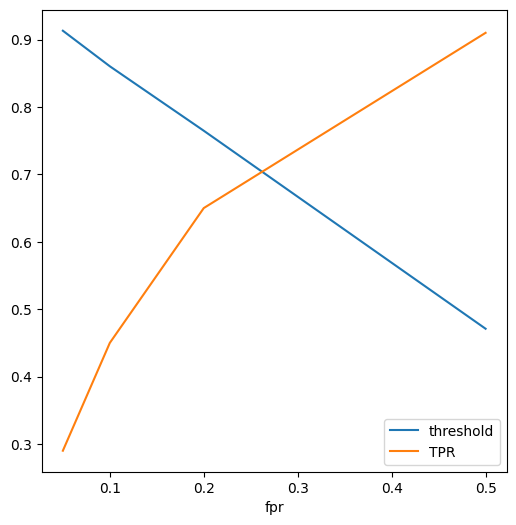

In [72]:
df.plot(x="fpr", y=["threshold", "TPR"], kind="line", figsize=(6, 6))

Смторя на графики моделей с двумя лоссами, мы можем сделать вывод, что модель с Triplet Loss даже на самом маленьком значении порога fpr показывает большее значение identification rate метрики, нежели чем модель с contrastive loss (0.17 против 0.29), а значит именно эту модель мы можем выбрать в качестве наилучшей для распознания лиц людей на фото.